In [1]:
import matplotlib_scalebar
from packaging import version
# We require an up to date version of matplotlib_scalebar. 
if not version.parse(matplotlib_scalebar.__version__) > version.parse("0.8.1"):
    ! pip install git+https://github.com/ppinard/matplotlib-scalebar
    print("Please restart your jupyter notebook.")

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import patato as pat

from learned_decolouring.patato_utils import LearnedSO2Calculator

from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib
import scienceplots  # noqa: F401
from palettable.cartocolors.qualitative import Safe_2

from patato.useful_utilities import add_axis_label, linear_regression

%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

plt.style.use(["science", "nature", "no-latex"])

matplotlib.rcParams["font.sans-serif"] = ["Arial"]
matplotlib.rcParams["figure.constrained_layout.use"] = True

In [3]:
def smooth(image, size=2):
    from scipy.signal import convolve2d

    return convolve2d(image, np.ones((size, size)) / size**2, mode="same")

In [4]:
reflectance_data = np.load("../data/reflectance/intermediate_results.npz")

fp1_mvf = 0.02
fp6_mvf = 0.4

fp_labels = (
    lambda x: ["I", "II", "III", "IV", "V", "VI"][x - 1]
    if x > 0 and x < 7
    else "Below I"
    if x <= 0
    else "Above VI"
)

In [5]:
def load_folder(folder_data, n_vessel, mvf_scale, n_skin):
    folder = Path(folder_data)
    files = glob.glob(str(folder / "*.npz"))
    file_example = np.load(files[0])
    plt.imshow(file_example["seg"][0] == n_skin)
    # plt.colorbar()
    plt.show()
    results = []

    unmixer = pat.SpectralUnmixer(
        chromophores=["Hb", "HbO2"],
        wavelengths=file_example["wavelength"],
        rescaling_factor=1,
    )
    so2_calculator = pat.SO2Calculator()
    thb_calculator = pat.THbCalculator()
    learned_calculator = LearnedSO2Calculator(
        model_path="learned_decolouring/models_GBR_all", model="SKIN"
    )

    for f in files:
        data = np.load(f)
        spectrum = np.mean(data["p0"].T[data["seg"][0].T == n_vessel].T, axis=-1)

        # Do spectral unmixing
        p0 = pat.Reconstruction(
            data["p0"][None, :, None],
            field_of_view=(1, 1, 1),
            ax_1_labels=data["wavelength"],
        )
        p0.raw_data *= 10000  # Rescale to remove decimals
        um, _, _ = unmixer.run(p0, None)
        thb, _, _ = thb_calculator.run(um, None)
        so2, _, _ = so2_calculator.run(um, None)

        import warnings

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Note: this function gives a warning as we're using the wrong
            # version of SciKitLearn...
            learned_so2, _, _ = learned_calculator.run(p0[:, ::2], None)

        seg = data["seg"][0] == n_vessel
        mean_sig = np.mean(data["p0"], axis=0)
        seg &= mean_sig >= np.percentile(mean_sig[seg], 80)

        so2_mean = np.mean(np.squeeze(so2.raw_data)[seg])
        learned_so2_mean = np.mean(np.squeeze(learned_so2.raw_data)[seg])

        mvf = data["mvf"]
        fp = int(
            np.round(
                5
                * (np.log10(mvf * mvf_scale) - np.log10(fp1_mvf))
                / (np.log10(fp6_mvf) - np.log10(fp1_mvf))
                + 1
            )
        )
        results.append(
            dict(
                spectrum=spectrum,
                wavelength=data["wavelength"],
                mvf=mvf,
                oxy=data["artery_oxygenation"],
                fp=fp,
                so2=so2_mean,
                so2_learned=learned_so2_mean,
                rec_im=p0,
                um_im=um,
                so2_im=so2,
                thb_im=thb,
                seg_blood=data["seg"][0] == n_vessel,
                seg_epi=data["seg"][0] == n_skin,
                dx=data["dx_mm"],
            )
        )
    return pd.DataFrame(results)

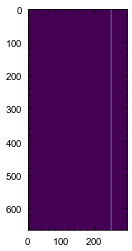

In [6]:
mvf_scale = 1
n_vessel = 5
n_skin = 4
folder_data = "../data/simulations/acuity optical simulation"
df = load_folder(folder_data, n_vessel, mvf_scale, n_skin)
df["format"] = "Skin Model"

In [7]:
for f in df.columns:
    if np.ndim(df[f].iloc[0]) == 0 and df[f].dtype == object:
        if isinstance(df[f].iloc[0], np.ndarray):
            df[f] = df[f].astype(df[f].iloc[0].dtype)

df["mvf"] *= 100

/var/folders/v4/tlcsrfts401cwf12yj4znlxw8cj3p3/T/ipykernel_93068/1295759884.py:49: RuntimeWarning: divide by zero encountered in log
  return np.interp(np.log(x), np.log(df_100["mvf"]), df_100["fp"])
/var/folders/v4/tlcsrfts401cwf12yj4znlxw8cj3p3/T/ipykernel_93068/1295759884.py:49: RuntimeWarning: divide by zero encountered in log
  return np.interp(np.log(x), np.log(df_100["mvf"]), df_100["fp"])
/var/folders/v4/tlcsrfts401cwf12yj4znlxw8cj3p3/T/ipykernel_93068/1295759884.py:49: RuntimeWarning: divide by zero encountered in log
  return np.interp(np.log(x), np.log(df_100["mvf"]), df_100["fp"])


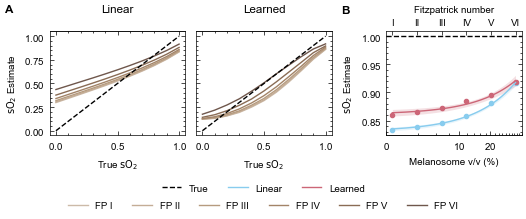

In [23]:
fig = plt.figure(figsize=(5.25, 5.25 / 3))
# subfiga, subfigb = fig.subfigures(1, 2, width_ratios=[2, 1])
ax1, ax2, ax3 = fig.subplots(1, 3)
ax1.sharex(ax2)
ax1.sharey(ax2)
# subfigb, subfigc = subfigbc.subfigures(1, 2, width_ratios=[3, 2])
# ax4 = subfigc.subplots()

for (n, formats), g in df.groupby(["fp", "format"]):
    g = g.sort_values("oxy")
    label = "FP " + fp_labels(n)

    fp_color = max(n - 1, 0)
    ax1.plot(g["oxy"], g["so2"], label=label, c=reflectance_data["rgbs"][fp_color])
    ax2.plot(
        g["oxy"], g["so2_learned"], label=label, c=reflectance_data["rgbs"][fp_color]
    )

ax1.plot([0, 1], [0, 1], c="k", linestyle="--")
ax2.plot([0, 1], [0, 1], c="k", linestyle="--")

# ax1.legend(frameon=False, ncol=2)
sax1 = ax1.secondary_xaxis("top")
sax1.set_xlabel("Linear", fontsize="large")
sax1.set_ticks([], [])

sax2 = ax2.secondary_xaxis("top")
sax2.set_xlabel("Learned", fontsize="large")
sax2.set_ticks([], [])

ax1.set_ylabel(r"$\mathrm{sO_2}$ Estimate")
ax1.set_xlabel(r"True $\mathrm{sO_2}$")
ax2.set_xlabel(r"True $\mathrm{sO_2}$")

df_100 = df.query("oxy == 1.").sort_values("fp")

x_plot = "fp"
ax3.scatter(df_100[x_plot], df_100["so2"], color=Safe_2.mpl_colors[0])
ax3.scatter(df_100[x_plot], df_100["so2_learned"], color=Safe_2.mpl_colors[1])
ax3.axhline(1, c="k", linestyle="--", label="True")


def forward(x):
    return np.exp(np.interp(x, df_100["fp"], np.log(df_100["mvf"])))


def backward(x):
    x[x <= 0] = 1e-9
    return np.interp(np.log(x), np.log(df_100["mvf"]), df_100["fp"])


fp = ["I", "II", "III", "IV", "V", "VI"]

ax3.set_xticks(np.arange(1, 7), fp, minor=False)
ax3.set_xticks([], [], minor=True)
ax3.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
secax = ax3.secondary_xaxis("bottom", functions=(forward, backward))
secax.set_xticks([0, 10, 20])
secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
secax.set_xlabel("Melanosome v/v (%)")

x_eval = np.linspace(np.min(df_100["mvf"]), np.max(df_100["mvf"]))

res, prediction = linear_regression(df_100["mvf"], df_100["so2"], x_predict=x_eval)
x_eval_plot = backward(x_eval)
ax3.plot(x_eval_plot, res.predicted_mean, color=Safe_2.mpl_colors[0], label="Linear")
ax3.fill_between(
    x_eval_plot,
    *res.conf_int().T,
    color=Safe_2.mpl_colors[0],
    linewidth=0,
    alpha=0.2,
    zorder=-100,
)
# print(prediction.pvalues)
# display(prediction.summary())

res, prediction = linear_regression(
    df_100["mvf"], df_100["so2_learned"], x_predict=x_eval
)
ax3.plot(x_eval_plot, res.predicted_mean, color=Safe_2.mpl_colors[1], label="Learned")
ax3.fill_between(
    x_eval_plot,
    *res.conf_int().T,
    color=Safe_2.mpl_colors[1],
    linewidth=0,
    alpha=0.2,
    zorder=-100,
)
# print(prediction.pvalues)
# display(prediction.summary())
l3, h3 = ax3.get_legend_handles_labels()
l2, h2 = ax2.get_legend_handles_labels()
fig.legend(
    l3, h3, frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 0)
)  # , title=r"$\mathrm{sO_2}$ Estimate")

fp_legend_name = "Fitzpatrick Type"
fig.legend(
    l2, h2, frameon=False, ncol=6, loc="upper center", bbox_to_anchor=(0.5, -0.1)
)  # , title=fp_legend_name)
# ax4.axis("off")

ax3.set_xlabel("Fitzpatrick number")
ax3.xaxis.set_label_position("top")
ax3.set_ylabel(r"$\mathrm{sO_2}$ Estimate")

plt.setp(ax2.yaxis.get_ticklabels(), visible=False)

fig.align_labels([ax1, ax2, secax])
fig._align_label_groups["x"].join(ax3, sax1)
fig._align_label_groups["x"].join(ax3, sax2)

add_axis_label(ax1, "A")
# add_axis_label(ax2, "B")
# add_subfigure_label(subfigb, ax3, "C")
add_axis_label(ax3, "B")


fig.savefig("../figures/all_ox_plot_SKINMODEL.png", dpi=300)
fig.savefig("../figures/all_ox_plot_SKINMODEL.pdf", dpi=300)
fig.savefig("../figures/figure_002.pdf", dpi=300)
plt.show()

In [9]:
def fix_clims(ims, lower=None, upper=None):
    min_c = np.inf
    max_c = -np.inf
    for i in ims:
        a, b = i.get_clim()
        if min_c > a:
            min_c = a
        if max_c < b:
            max_c = b
    if lower is not None:
        min_c = lower
    if upper is not None:
        max_c = upper
    for i in ims:
        i.set_clim((min_c, max_c))

In [10]:
df_high = df[df["oxy"] > 0.99].set_index("fp")
df_high["fp"] = df_high.index

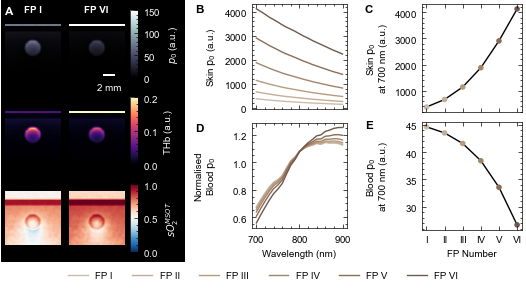

In [19]:
sample_indices = [0, -1]
n_samples = len(sample_indices)

log = False

fig = plt.figure(figsize=(5.25, 1.5 * 5.25 / 3))
subfiga, subfigb = fig.subfigures(1, 2, width_ratios=(1.1, 2))
metric_name = "$p_0$"
output_name = "p0"
subsubfiga, subsubfigb = subfigb.subfigures(1, 2)
rgb = reflectance_data["rgbs"]
# Right plots
ax1, ax2 = subsubfiga.subplots(2)
ax3, ax4 = subsubfigb.subplots(2)
rgbs = reflectance_data["rgbs"]

df_high["Skin Spectrum"] = pd.Series(dtype=object)
df_high["Blood Spectrum"] = pd.Series(dtype=object)

for fp, d in df_high.iterrows():
    # Plot the skin spectrum
    skin_mask = d["seg_epi"]
    skin_spectrum = np.mean(np.squeeze(d["rec_im"].raw_data).T[skin_mask.T], axis=0)
    df_high.at[fp, "Skin Spectrum"] = skin_spectrum
    ax1.plot(
        d["wavelength"], skin_spectrum, c=rgbs[max(fp - 1, 0)], label=f"FP {fps[d['fp']-1]}"
    )

    blood_mask = d["seg_blood"]

    blood_spectrum = np.mean(np.squeeze(d["rec_im"].raw_data).T[blood_mask.T], axis=0)
    df_high.at[fp, "Blood Spectrum"] = blood_spectrum.copy()
    blood_spectrum /= np.mean(blood_spectrum)
    ax2.plot(d["wavelength"], blood_spectrum, c=rgbs[max(fp - 1, 0)])

ax2.sharex(ax1)
ax1.set_ylabel(r"Skin $\mathrm{p_0}$ (a.u.)")
ax2.set_ylabel("Normalised\nBlood $\\mathrm{p_0}$")
ax2.set_xlabel("Wavelength (nm)")

ax1.tick_params(labelbottom=False)

wl_plot = (
    df_high.explode(["wavelength", "Blood Spectrum", "Skin Spectrum"])
    .set_index("wavelength")
    .loc[700, :]
)

x_axis = "fp"
ax3.plot(wl_plot[x_axis], wl_plot["Skin Spectrum"], c="k", zorder=-100)

fp_colour = wl_plot["fp"].copy()
fp_colour[fp_colour < 1] = 1
ax3.scatter(wl_plot[x_axis], wl_plot["Skin Spectrum"], c=rgb[fp_colour - 1])

# print("\n".join([f"FP: {fp}, skin value: {s}" for fp, s in zip(wl_plot["fp"], wl_plot["Skin Spectrum"])]))

ax4.plot(wl_plot[x_axis], wl_plot["Blood Spectrum"], c="k", zorder=-100)
# print("\n".join([f"FP: {fp}, blood value: {s}" for fp, s in zip(wl_plot["fp"], wl_plot["Blood Spectrum"])]))
ax4.scatter(wl_plot[x_axis], wl_plot["Blood Spectrum"], c=rgb[fp_colour - 1])

fp = ["I", "II", "III", "IV", "V", "VI"]
ax3.set_xticks(range(1, 7), fp)
ax4.set_xticks(range(1, 7), fp)
ax4.set_xlabel("FP Number")

ax3.tick_params(labelbottom=False)
ax3.set_ylabel("Skin $\\mathrm{p_0}$\nat 700 nm (a.u.)")
ax4.set_ylabel("Blood $\\mathrm{p_0}$\nat 700 nm (a.u.)")

# Left plots:

im_grid = subfiga.subplots(3, n_samples, sharex=True, sharey=True)

cmap = matplotlib.colormaps["bone"]
cmap.set_bad("k")

ims1 = []
ims_thb = []
ims_so2 = []
fps = ["I", "II", "III", "IV", "V", "VI"]

overlay_image = [
    None,
    r"$\mathbf{log(THb)}$" if log else r"$\mathbf{THb}$",
    r"$\mathbf{sO_2^{MSOT}}$",
]

ims = []
ims_thb = []
cbars = []

for i in range(n_samples):
    overlay = ""
    # overlay = overlay_image[i//n_samples]
    rec = df_high.iloc[sample_indices[i]]["rec_im"]
    # For visualisation purposes, downsample the image (epidermis is only one
    # pixel thick, so invisible otherwise)
    image = np.squeeze(rec.raw_data[0, 0, :, :].T)
    if log:
        image = np.log10(image)
    image = smooth(image, 7)

    for j in range(3):
        im = im_grid[j, i].imshow(
            image, origin="lower", cmap=cmap, interpolation="none"
        )
        ims.append(im)
    mx = rec.raw_data.shape[3] // 2
    my = rec.raw_data.shape[4] // 2
    # print(rec.shape, my, mx)
    im_grid[0, i].set_xlim([mx - 75, mx + 75])
    im_grid[0, i].set_ylim([my - 25, my + 120])

    for j in range(3):
        im_grid[j, i].axis("off")

    thb = df_high.iloc[sample_indices[i]]["thb_im"]
    image = thb.raw_data[0, 0, :, :].T
    if log:
        image = np.log10(image)
    thb_to_plot = smooth(np.squeeze(image).copy(), 7)
    seg_blood = df_high.iloc[i % n_samples]["seg_blood"].T

    im_thb = im_grid[1, i].imshow(
        thb_to_plot, origin="lower", cmap="magma", interpolation="none"
    )
    ims_thb.append(im_thb)
    if i == 0:
        cbar = plt.colorbar(im_thb, ax=im_grid[1], aspect=8)
        cbar.set_label(r"$\log(THb)$ (a.u.)" if log else "THb (a.u.)", color="w")
        cbar.ax.tick_params(labelcolor="w")
        cbars.append(cbar)

    so2 = df_high.iloc[sample_indices[i]]["so2_im"]
    so2_to_plot = smooth(np.squeeze(so2.raw_data[0, 0, :, :].T).copy(), 7)
    seg_blood = df_high.iloc[i]["seg_blood"].T

    im_so2 = im_grid[2, i].imshow(
        so2_to_plot, origin="lower", cmap="RdBu_r", interpolation="none"
    )
    ims_so2.append(im_so2)
    if i == 0:
        cbar = plt.colorbar(im_so2, ax=im_grid[2], aspect=8)
        cbar.set_label("$sO_2^{MSOT}$", color="w")
        cbar.ax.tick_params(labelcolor="w")
        cbars.append(cbar)
        cbar = plt.colorbar(im, ax=im_grid[0], aspect=8)
        cbar.set_label(r"$\log(p_0)$\n(a.u.)" if log else r"$p_0$ (a.u.)", color="w")
        cbar.ax.tick_params(labelcolor="w")
        cbars.append(cbar)
        scalebar = ScaleBar(
            df_high.iloc[sample_indices[i]]["dx"],
            "mm",
            fixed_value=2,
            width_fraction=0.05,
            box_alpha=0.0,
            location="upper right",
            color="white",
            bbox_to_anchor=(1, 0),
            bbox_transform=im_grid[0, -1].transAxes,
        )
        im_grid[0, -1].add_artist(scalebar)

fix_clims(ims_thb, lower=0, upper=0.2)
fix_clims(ims, lower=0, upper=150)

fix_clims(ims_so2, lower=0, upper=1)
# Now add subfigure labels.
labels = ["a", "b", "c", "d", "e"]

y_0 = ax1.get_position().ymax

axes = [im_grid[0], ax1, ax2, ax3, ax4]
subfigure_positions = [(0, 1)] + [
    (0, ax.get_position()) for i, ax in enumerate([ax1, ax2, ax3, ax4])
]

for i, label_ax in enumerate(im_grid[0]):
    label_ax.annotate(
        "FP " + fps[sample_indices[i]],
        xy=(0.5, 1.05),
        xycoords="axes fraction",
        ha="center",
        va="bottom",
        fontsize="medium",
        color="w",
        fontweight="bold",
    )

label = add_axis_label(im_grid[0, 0], "A")
label.set_color("w")
add_axis_label(ax1, "B")
add_axis_label(ax3, "C")
add_axis_label(ax2, "D")
add_axis_label(ax4, "E")
subsubfiga.align_labels()
subsubfigb.align_labels()
subfiga.align_labels()
subfigb.align_labels()
fig.align_labels()

ax3.set_xticks([], [], minor=True)
ax4.set_xticks([], [], minor=True)

subfiga.set_facecolor("k")

for i in range(1, len(cbars)):
    fig._align_label_groups["y"].join(cbars[0].ax, cbars[i].ax)

fig.legend(
    *ax1.get_legend_handles_labels(),
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    ncols=6,
)

plt.savefig(f"../figures/sim_figure_{output_name}_SKINMODEL.png", dpi=300)
plt.savefig(f"../figures/sim_figure_{output_name}_SKINMODEL.pdf", dpi=300)
plt.savefig(f"../figures/figure_001.pdf", dpi=300)
plt.show()